# Medicare Claims Analysis

Medicare is USA's largest government insurance program. It caters to US senior citizens aged 65+, and youths with disabilities. The program is adminstered by CMS (Center for Medicare and Medicaid Services). The data linked is from the CMS Website.


### Guidelines for the task
- Take the time to understand the business problem and to develop a thoughtful solution, we suggest taking a few hours to complete the task.
- Be prepared to talk through what you did during the task to a technical & non-technical audience.
- If there are parts of this EDA that you would do differently, or with more time, would try something else, please discuss these during the interview. 
- Please share code & relevant materials (slides, workbooks etc..) at least 24 hours prior to the interview



## Central Question: How does cost vary across different providers for different conditions?

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
%run helper_functions.py
%load_ext autoreload

In [3]:
slide_background_color = get_slide_background_color()
def set_preferred_options():
    pd.set_option('display.max_columns', None)
    pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))
    plt.style.use('dark_background')
    plt.facecolor=(slide_background_color)
    matplotlib.rcParams['font.sans-serif'] = "Arial"
    matplotlib.rcParams['font.family'] = "sans-serif"
set_preferred_options()

### Read the data

In [4]:
def get_data(file_path, char_columns):
    dtype_options = {column: "str" for column in char_columns}
    df = pd.read_csv(file_path, dtype=dtype_options)
    return df

In [96]:
beneficiary_file_path = "./data/DE1_0_2009_Beneficiary_Summary_File_Sample_20.csv"
char_columns_in_beneficiary_data = [
    'BENE_SEX_IDENT_CD',
    'BENE_RACE_CD',
    'BENE_ESRD_IND',
    'SP_STATE_CODE',
    'SP_ALZHDMTA',
    'SP_CHF',
    'SP_CHRNKIDN',
    'SP_CNCR',
    'SP_COPD',
    'SP_DEPRESSN',
    'SP_DIABETES',
    'SP_ISCHMCHT',
    'SP_OSTEOPRS',
    'SP_RA_OA',
    'SP_STRKETIA'
]	


claims_file_path = "./data/DE1_0_2008_to_2010_Outpatient_Claims_Sample_20.csv"
char_columns_in_claims_data = [
    'ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2',
    'ICD9_DGNS_CD_3','ICD9_DGNS_CD_4' ,'ICD9_DGNS_CD_5',
    'ICD9_DGNS_CD_6', 'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8',
    'ICD9_DGNS_CD_9', 'ICD9_DGNS_CD_10',
    'ICD9_PRCDR_CD_1', 'ICD9_PRCDR_CD_2', 'ICD9_PRCDR_CD_3',
    'ICD9_PRCDR_CD_4', 'ICD9_PRCDR_CD_5', 'ICD9_PRCDR_CD_6'     
]



In [97]:
beneficiary_df = get_data(beneficiary_file_path, 
                          char_columns_in_beneficiary_data)
claims_df = get_data(claims_file_path,
                     char_columns_in_claims_data)

In [7]:
beneficiary_df = get_beneficiary_age(beneficiary_df,
                                     'BENE_BIRTH_DT',
                                     reference_date_str='20101212'
                                     )


### Descriptive Graphs

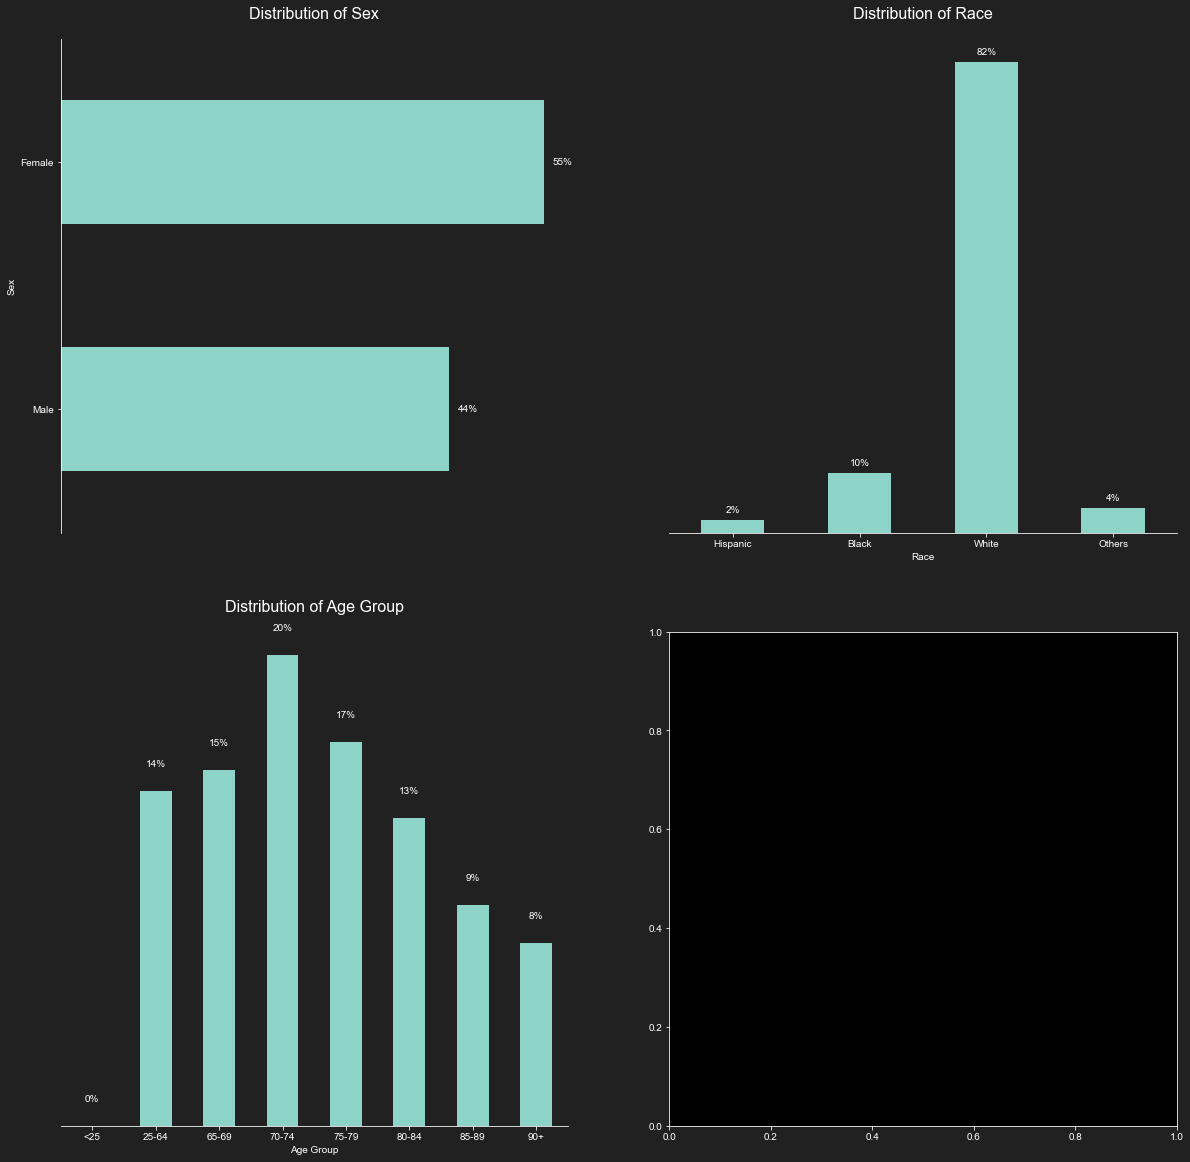

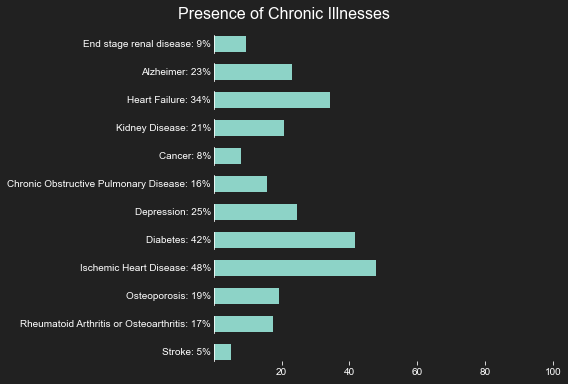

In [8]:
def generate_descriptive_graphs_beneficiary(beneficiary_df):
    sex_labels = {'1':'Male', '2':'Female'}
    race_labels = {'1': 'White', '2': 'Black', '3': 'Others', '5': 'Hispanic'}
    sp_conditions_map = {
    'Yes':'1',
    'No':'2'
    }
    esrd_conditions_map = {
        'No':'0',
        'Yes':'Y'
    }
    conditions_readable_map = {
        'BENE_ESRD_IND':['End stage renal disease', esrd_conditions_map],
        'SP_ALZHDMTA':['Alzheimer', sp_conditions_map],
        'SP_CHF':['Heart Failure', sp_conditions_map],
        'SP_CHRNKIDN':['Kidney Disease', sp_conditions_map],
        'SP_CNCR':['Cancer', sp_conditions_map],
        'SP_COPD':['Chronic Obstructive Pulmonary Disease', sp_conditions_map],
        'SP_DEPRESSN':['Depression', sp_conditions_map],
        'SP_DIABETES':['Diabetes', sp_conditions_map],
        'SP_ISCHMCHT':['Ischemic Heart Disease', sp_conditions_map],
        'SP_OSTEOPRS':['Osteoporosis', sp_conditions_map],
        'SP_RA_OA':['Rheumatoid Arthritis or Osteoarthritis', sp_conditions_map],
        'SP_STRKETIA':['Stroke' , sp_conditions_map],
    }

    age_labels = {
        '1': '<25',
        '2': '25-64',
        '3': '65-69',
        '4': '70-74',
        '5': '75-79',
        '6': '80-84',
        '7': '85-89',
        '8': '90+',
    }
    fig, axs = plt.subplots(
        nrows=2,
        ncols=2,
        figsize=(20, 20),
        facecolor=slide_background_color
    )

    generate_horizontal_bar_graph(ax=axs[0, 0],
                                  df=beneficiary_df, 
                                  variable="BENE_SEX_IDENT_CD",
                                  chart_title="",
                                  variable_readable="Sex",
                                  variable_labels=sex_labels)
    
    generate_vertical_bar_graph(ax=axs[0, 1],
                                df=beneficiary_df, 
                                variable="BENE_RACE_CD",
                                chart_title="",
                                variable_readable="Race",
                                variable_labels=race_labels)
    
    generate_vertical_bar_graph(ax=axs[1, 0],
                                df=beneficiary_df, 
                                variable="age_group",
                                variable_readable="Age Group",
                                chart_title="",
                                variable_labels=age_labels)
    plt.show()
    generate_conditions_summary(beneficiary_df, conditions_readable_map)
    
generate_descriptive_graphs_beneficiary(beneficiary_df)

### Data Quality checks

- Beneficiary data is unique at `DESYNPUF_ID` - which represents the beneficiary code/ patient code according to documentation${^1}$

- The claims data is not unique on `CLM_ID`. However it is unique at `CLM_ID` x `Segment` level.
Wherever segment = 2, most of the variables are `NaN`s, excepting Provider Institution. From looking at this data, my hypothesis is that the claims were amended, with a new Provider Info, or claim amount. For this analysis, I'm dropping the rows where the segment = 2, and most of the variables are `NaN`

- There are some claims where the `CLM_PMT_AMT` is negative, which can occur in
the following cases:
    - Where the beneficiary is charged a coinsurance amount and this is higher than the amount Medicare pays
    - Where the deductible exceeds the amount Medicare pays
    
    In both the above situations the claim amount does not represent the cost of the treatment, hence this has been removed from the dataset

- `MEDREIMB_OP` in the beneficiary dataset denotes the total annual medical Outpatient Reimbursement from Medicaid. There are some beneficiaries in the dataset that have negative due to similar reasons as for `CLM_PMT_AMT`. However these are not removed, as their could be non-negative claim amounts from the same benficiary. I've replaced negative values with
0 for this dataset.



In [11]:
duplicate_claims = claims_df[claims_df.duplicated(subset=['CLM_ID'], keep=False)]
print(f"Percentage of data removed due to duplicates:\
      {100* len(duplicate_claims)/len(claims_df)}")

claims_df = claims_df.drop_duplicates(subset=['CLM_ID'])
claims_df = claims_df[claims_df['CLM_PMT_AMT'] >= 0]

beneficiary_df['MEDREIMB_OP'] = beneficiary_df['MEDREIMB_OP'].clip(lower=0)



Percentage of data removed due to duplicates:      0.0


### New column creation
#### For illness condition

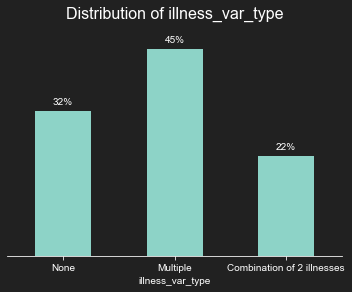

In [14]:
conditions_to_combine = {'SP_ALZHDMTA': 'Alzheimer',
                      'SP_CHF': 'Heart Failure',
                      'SP_CHRNKIDN': 'Kidney Disease',
                      'SP_CNCR': 'Cancer',
                      'SP_COPD': 'COPD', 
                      'SP_DEPRESSN': 'Depression',
                      'SP_DIABETES': 'Diabetes',
                      'SP_ISCHMCHT': 'Ischemic Heart Disease',
                      'SP_OSTEOPRS': 'Osteoporosis',
                      'SP_RA_OA': 'Rheumatoid Arthritis or Osteoarthritis',
                      'SP_STRKETIA': 'Stroke'  
}
sp_conditions_map = {
'Yes':'1',
'No':'2'
}
esrd_conditions_map = {
    'No':'0',
    'Yes':'Y'
}
conditions_readable_map = {
    'BENE_ESRD_IND':['End stage renal disease', esrd_conditions_map],
    'SP_ALZHDMTA':['Alzheimer', sp_conditions_map],
    'SP_CHF':['Heart Failure', sp_conditions_map],
    'SP_CHRNKIDN':['Kidney Disease', sp_conditions_map],
    'SP_CNCR':['Cancer', sp_conditions_map],
    'SP_COPD':['Chronic Obstructive Pulmonary Disease', sp_conditions_map],
    'SP_DEPRESSN':['Depression', sp_conditions_map],
    'SP_DIABETES':['Diabetes', sp_conditions_map],
    'SP_ISCHMCHT':['Ischemic Heart Disease', sp_conditions_map],
    'SP_OSTEOPRS':['Osteoporosis', sp_conditions_map],
    'SP_RA_OA':['Rheumatoid Arthritis or Osteoarthritis', sp_conditions_map],
    'SP_STRKETIA':['Stroke' , sp_conditions_map],
}


beneficiary_df['combined_condition'] = beneficiary_df.apply(combine_conditions, 
                                    columns_to_combine=conditions_readable_map, 
                                    axis=1)
beneficiary_df['combined_condition'].value_counts()
beneficiary_df = get_illness_var_type(beneficiary_df)
generate_vertical_bar_graph(df=beneficiary_df, 
                        variable="illness_var_type")


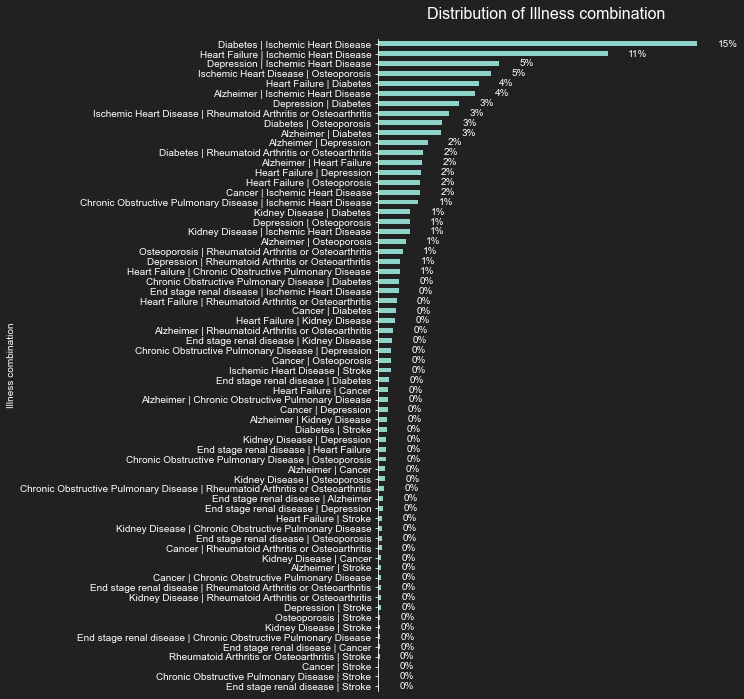

In [15]:
illness_combination_df = beneficiary_df[
    beneficiary_df['combined_condition'].str.contains('\&')
    ]
generate_horizontal_bar_graph(df=illness_combination_df,
                            variable="combined_condition", 
                            chart_title="", 
                            variable_readable="Illness combination")

### Data join

### Data quality after join
- There are 30,077 beneficiaries that do not have any claims, and 86% of them 
has no chronic illness.
- There are ~2k OP claims without beneficiaries, which is 0.25% of the data.

Onward with the remaining analysis!

In [18]:
print(f"# of rows in beneficiary data: {len(beneficiary_df)}")
print(f"# of rows in claims data:  {len(claims_df)}")
beneficiary_claims_df = pd.merge(beneficiary_df, claims_df, 
                                 on='DESYNPUF_ID', how='inner')
print(f'# of rows in joined data: {len(beneficiary_claims_df)}')

# of rows in beneficiary data: 114641
# of rows in claims data:  776670
# of rows in joined data: 774693


In [41]:
merged_df = pd.merge(beneficiary_df, claims_df, on='DESYNPUF_ID', how='outer', indicator=True)

claims_missing_beneficiary = merged_df[merged_df['_merge'] == 'right_only']
beneficiary_missing_claims = merged_df[merged_df['_merge'] == 'left_only']
print(f"Beneficiaries without claims: {len(beneficiary_missing_claims)}")
print(f"Claims without beneficiaries: {len(claims_missing_beneficiary)}")
print(f" %Claims without beneficiaries:\
      {round(100 * len(claims_missing_beneficiary)/len(claims_df), 2)}")

Beneficiaries without claims: 30077
Claims without beneficiaries: 1977
 %Claims without beneficiaries:      0.25


In [42]:
beneficiary_missing_claims['TOTAL_SUM'] = (
    beneficiary_missing_claims['MEDREIMB_IP'] + 
    beneficiary_missing_claims['MEDREIMB_CAR']
)

conditions = [
    beneficiary_missing_claims['TOTAL_SUM'] > 0,
    beneficiary_missing_claims['combined_condition'] == 'None'
]

choices = [
    "Has other claims",
    "No illnesses"
]

beneficiary_missing_claims.loc[:, 'missing_reason'] = np.select(
    conditions, choices, default="Missing claims")

print(beneficiary_missing_claims['missing_reason']
      .value_counts(normalize=True) * 100)


No illnesses       68.41
Has other claims   31.17
Missing claims      0.42
Name: missing_reason, dtype: float64


/Users/anjalikarimpil/projects/takehome-challenges/UHG-DS/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/anjalikarimpil/projects/takehome-challenges/UHG-DS/venv/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/anjalikarimpil/projects/takehome-challenges/UHG-DS/venv

Which chronic illness combination has the total highest cost?
Which chronic illness combination has the highest cost per member?




### Benchmarking

The aim here is to understand the distribution of cost across providers treating members with these chronic illnesses. Benchmarking providers across types of care is often a helpful starting point to begin solutioning for areas of high cost.

For each provider (use AT_PHYSN_NPI) & chronic illness, calculate the cost per member.
For each chronic illness combination, represent the distribution of costs per provider.
How does this change if we filter out cases where a given Chronic Illness & Provider NPI combination only has 1 member?
Which providers are consistently expensive across chronic illnesses they treat?


In [43]:

condition_grouped_df = beneficiary_claims_df.groupby('combined_condition').agg(
    total_cost=('CLM_PMT_AMT', 'sum'),
    beneficiary_count=('DESYNPUF_ID', 'nunique'),  
    claim_count=('CLM_ID', 'count')  
).reset_index()

condition_grouped_df['cost_per_member_per_illness'] = (condition_grouped_df['total_cost'] / 
                                                       condition_grouped_df['beneficiary_count'])

condition_grouped_df.sort_values(by='total_cost', 
                                 ascending=False, 
                                 inplace=True)

condition_grouped_df.head(20)


,combined_condition,total_cost,beneficiary_count,claim_count,cost_per_member_per_illness
72,Multiple,169465320.00,51333,597369,3301.29
73,None,7507760.00,10802,34928,695.03
59,Ischemic Heart Disease,4154450.00,3409,18609,1218.67
33,Diabetes | Ischemic Heart Disease,2941930.00,1856,13642,1585.09
32,Diabetes,2250410.00,1673,10729,1345.13
54,Heart Failure | Ischemic Heart Disease,1891530.00,1286,8884,1470.86
26,Depression,1412450.00,1186,6623,1190.94
49,Heart Failure,1158360.00,1131,5641,1024.19
28,Depression | Ischemic Heart Disease,1102670.00,694,4906,1588.86
74,Osteoporosis,1066700.00,972,5184,1097.43


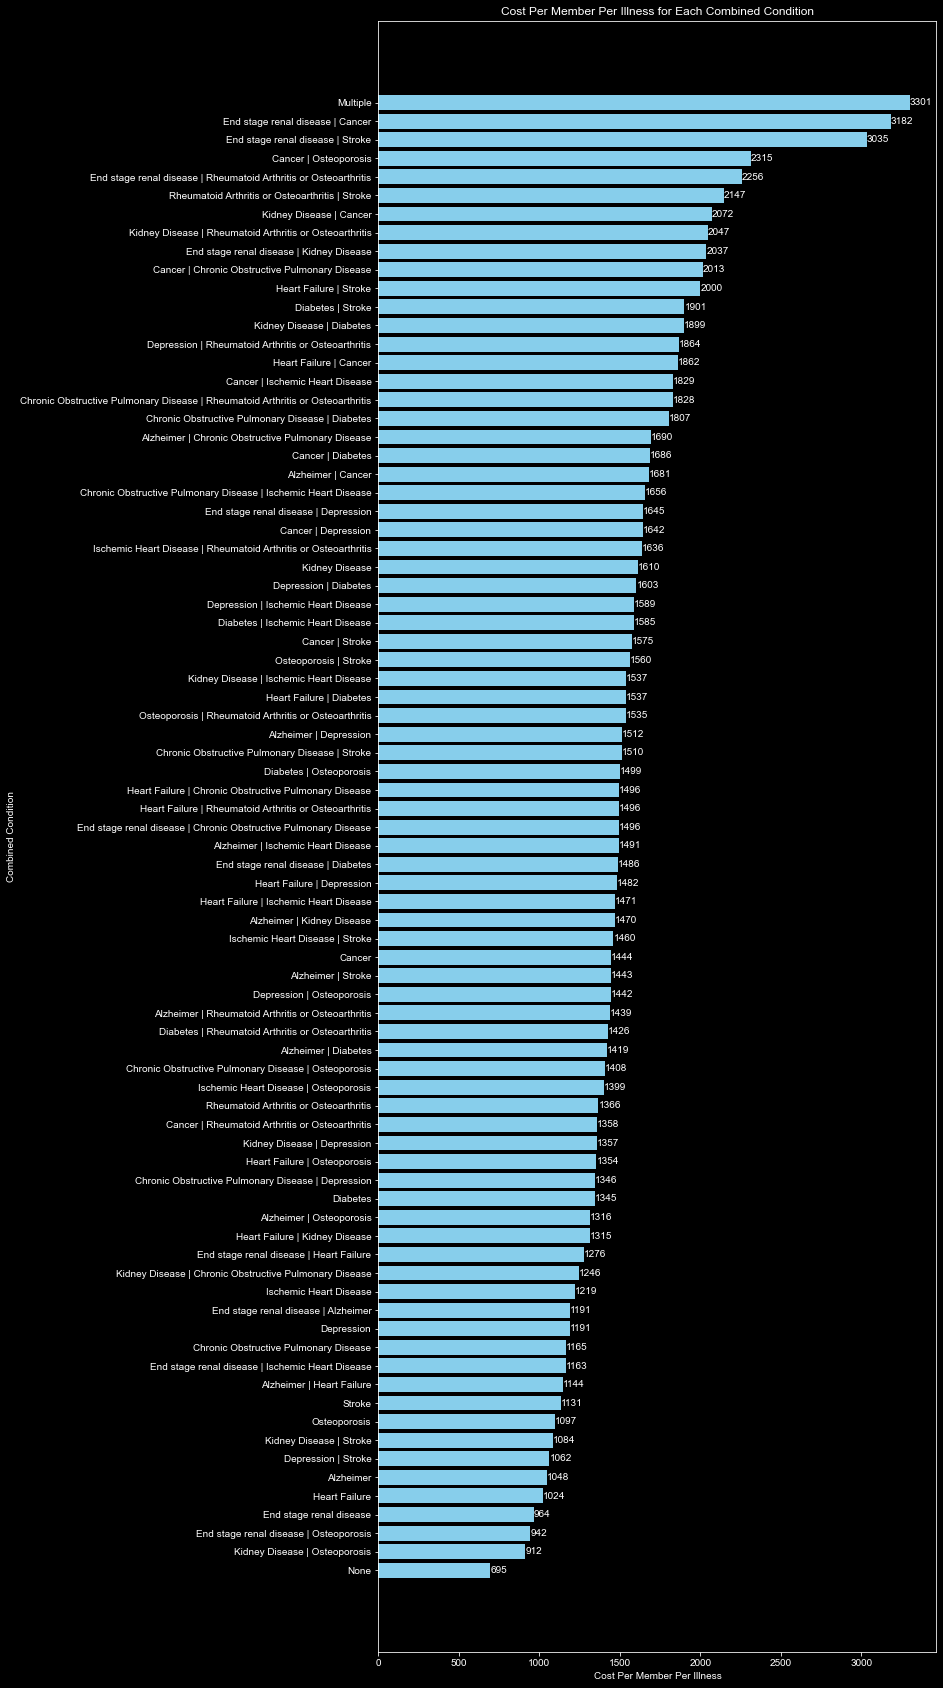

In [44]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame condition_grouped_df

# Sort the DataFrame by total_cost in descending order
condition_grouped_df.sort_values(by='cost_per_member_per_illness', ascending=True, inplace=True)

# Create a horizontal bar graph
fig, ax = plt.subplots(figsize=(10, 30))
bars = ax.barh(condition_grouped_df['combined_condition'], condition_grouped_df['cost_per_member_per_illness'], color='skyblue')

# Add labels to the right of the bars
for bar, cost_per_member in zip(bars, condition_grouped_df['cost_per_member_per_illness']):
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height() / 2, f'{cost_per_member:.0f}', ha='left', va='center')

# Set labels and title
ax.set_xlabel('Cost Per Member Per Illness')
ax.set_ylabel('Combined Condition')
ax.set_title('Cost Per Member Per Illness for Each Combined Condition')

# Display the plot
plt.show()


/Users/anjalikarimpil/projects/takehome-challenges/UHG-DS/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


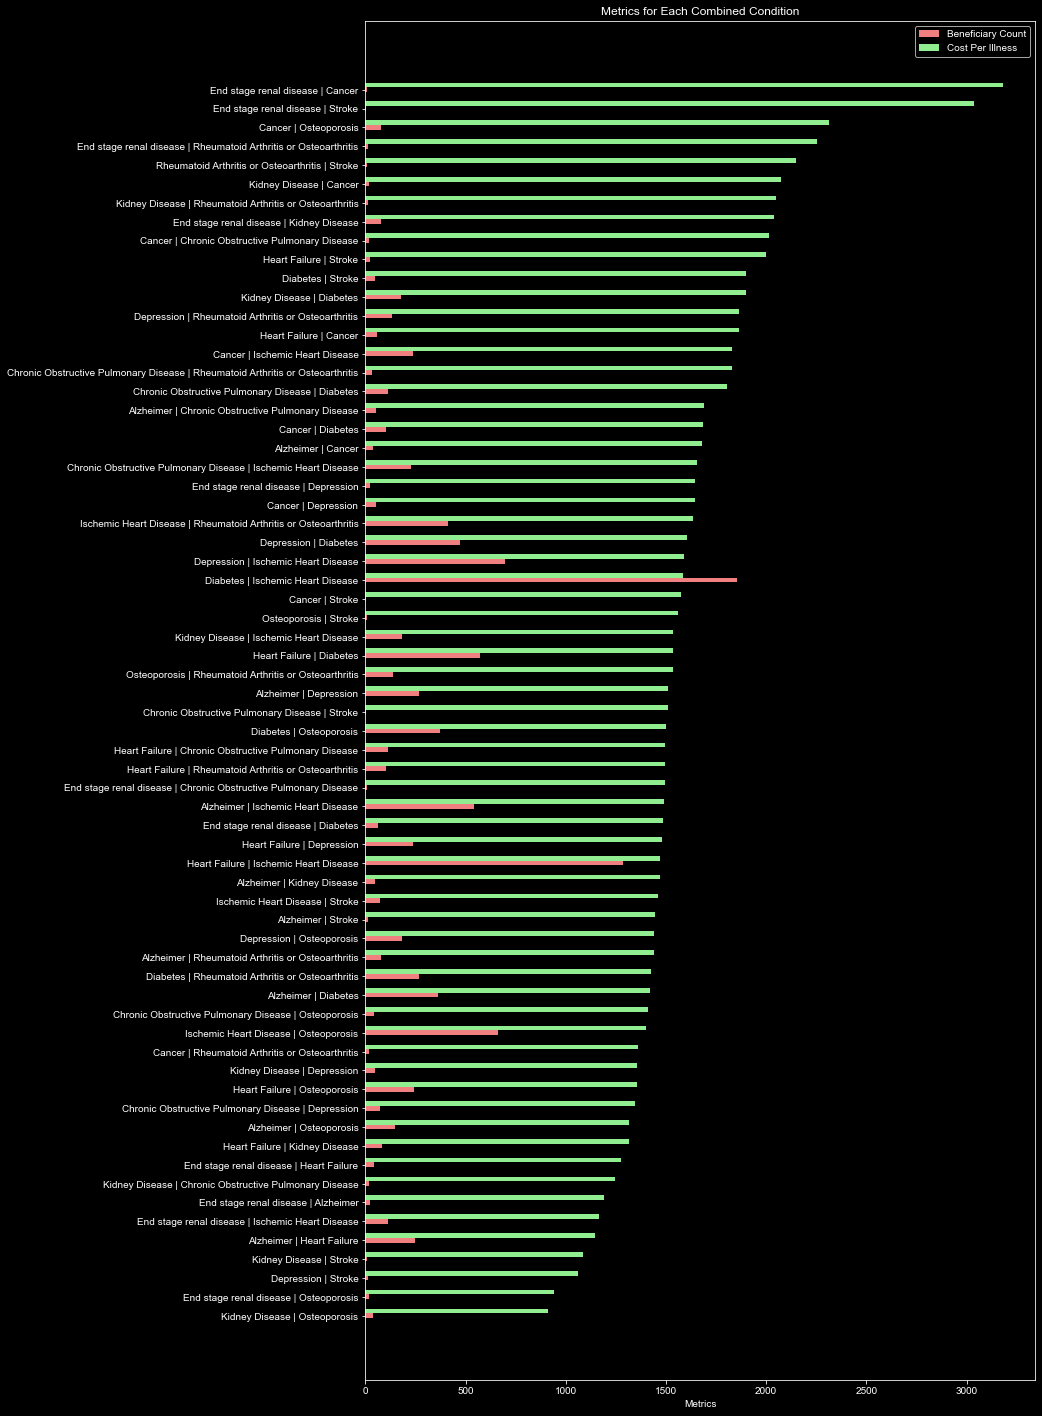

In [56]:
condition_grouped_df_comb2 = condition_grouped_df[
    condition_grouped_df['combined_condition'].str.contains('\&')
    ]

# Sort the DataFrame by total_cost in descending order
condition_grouped_df_comb2.sort_values(by='cost_per_member_per_illness', ascending=True, inplace=True)

# Create a horizontal clustered bar graph
fig, ax = plt.subplots(figsize=(12, 25))

bar_width = 0.25  # Width of each bar
index = range(len(condition_grouped_df_comb2))

# Bar for beneficiary_count
bars_beneficiary_count = ax.barh([i + bar_width for i in index], condition_grouped_df_comb2['beneficiary_count'], bar_width, label='Beneficiary Count', color='lightcoral')

# Bar for cost_per_illness
bars_cost_per_illness = ax.barh([i + 2 * bar_width for i in index], condition_grouped_df_comb2['cost_per_member_per_illness'], bar_width, label='Cost Per Illness', color='lightgreen')

# Set y-axis ticks and labels
ax.set_yticks([i + bar_width for i in index])
ax.set_yticklabels(condition_grouped_df_comb2['combined_condition'])

# Set labels and title
ax.set_xlabel('Metrics')
ax.set_title('Metrics for Each Combined Condition')
ax.legend()

# Display the plot
plt.show()


In [54]:
member_grouped_df = (beneficiary_claims_df
                     .groupby(['DESYNPUF_ID', 'combined_condition'])
                     .agg(physician_count=('AT_PHYSN_NPI', 'nunique'),
                          cost=('CLM_PMT_AMT', 'sum')
                          )
                    )


# (member_grouped_df
#  .groupby(['combined_condition'])
#  .agg(num_physicians=('physician_count', 'sum'),
#       median_cost_per_member_per_illness=('cost', 'median') 
#       )
#  )

In [55]:
provider_condition_grouped_df = (beneficiary_claims_df
                                 .groupby(['AT_PHYSN_NPI', 'combined_condition'])
                                 .agg(total_cost=('CLM_PMT_AMT', 'sum'),
                                     beneficiary_count=('DESYNPUF_ID', 'nunique'),
                                    )
                                ).reset_index()

provider_condition_grouped_df['cost_per_member_per_provider'] = (
    provider_condition_grouped_df['total_cost'] / 
    provider_condition_grouped_df['beneficiary_count'])

provider_condition_grouped_df.sort_values(by='cost_per_member_per_provider', 
                                 ascending=False, 
                                 inplace=True)

provider_condition_grouped_df.head(20)

,AT_PHYSN_NPI,combined_condition,total_cost,beneficiary_count,cost_per_member_per_provider
89716,4434265417.00,Ischemic Heart Disease | Osteoporosis,7920.00,1,7920.00
47376,2371639354.00,Rheumatoid Arthritis or Osteoarthritis,7680.00,1,7680.00
13667,682792263.00,Diabetes | Rheumatoid Arthritis or Osteoarthritis,7490.00,1,7490.00
199847,9943567290.00,End stage renal disease | Rheumatoid Arthritis...,7420.00,1,7420.00
116978,5811236759.00,Diabetes | Rheumatoid Arthritis or Osteoarthritis,6600.00,1,6600.00
72851,3600937944.00,Rheumatoid Arthritis or Osteoarthritis | Stroke,6290.00,1,6290.00
66620,3304695316.00,Multiple,6270.00,1,6270.00
99034,4902260259.00,Alzheimer | Depression,6240.00,1,6240.00
34238,1710533109.00,Heart Failure | Ischemic Heart Disease,6220.00,1,6220.00
54222,2713175762.00,Heart Failure | Diabetes,6020.00,1,6020.00


In [57]:
grouped_stats_df = pd.merge(provider_condition_grouped_df, condition_grouped_df, on=['combined_condition'])
# grouped_stats_df = grouped_stats_df.drop(['total_cost', 'beneficiary_count', 'claim_count'], axis=1)
grouped_stats_df['diff'] = grouped_stats_df['cost_per_member_per_illness'] - grouped_stats_df['cost_per_member_per_provider']
grouped_stats_df
grouped_stats_df = grouped_stats_df[grouped_stats_df['beneficiary_count_x'] > 1]

grouped_stats_df.sort_values(by=['AT_PHYSN_NPI','diff'], ascending=False)

,AT_PHYSN_NPI,combined_condition,total_cost_x,beneficiary_count_x,cost_per_member_per_provider,total_cost_y,beneficiary_count_y,claim_count,cost_per_member_per_illness,diff
85299,9999469755.00,Multiple,50.00,2,25.00,169465320.00,51333,597369,3301.29,3276.29
17301,9999354704.00,Multiple,4620.00,8,577.50,169465320.00,51333,597369,3301.29,2723.79
70762,9999234722.00,Multiple,180.00,3,60.00,169465320.00,51333,597369,3301.29,3241.29
51493,9999039484.00,Multiple,550.00,5,110.00,169465320.00,51333,597369,3301.29,3191.29
57478,9999035093.00,Multiple,280.00,3,93.33,169465320.00,51333,597369,3301.29,3207.96
...,...,...,...,...,...,...,...,...,...,...
10218,1159725.00,Multiple,3500.00,3,1166.67,169465320.00,51333,597369,3301.29,2134.63
20456,1053861.00,Multiple,8670.00,18,481.67,169465320.00,51333,597369,3301.29,2819.63
57614,1005544.00,Multiple,820.00,9,91.11,169465320.00,51333,597369,3301.29,3210.18
61092,511156.00,Multiple,160.00,2,80.00,169465320.00,51333,597369,3301.29,3221.29


In [58]:

# Filter out cases where there is only 1 member
provider_condition_grouped_df = provider_condition_grouped_df[provider_condition_grouped_df['beneficiary_count'] > 1]

# Calculate cost per member and add it to the DataFrame
provider_condition_grouped_df['cost_per_member'] = (

    provider_condition_grouped_df['total_cost'] / 
    provider_condition_grouped_df['beneficiary_count'])

provider_condition_grouped_df

,AT_PHYSN_NPI,combined_condition,total_cost,beneficiary_count,cost_per_member_per_provider,cost_per_member
189985,9453890658.00,Multiple,11960.00,2,5980.00,5980.00
155476,7734578250.00,Multiple,16940.00,3,5646.67,5646.67
175094,8712278179.00,Multiple,17340.00,4,4335.00,4335.00
103005,5088396912.00,Diabetes | Ischemic Heart Disease,8010.00,2,4005.00,4005.00
168836,8402307293.00,Multiple,22580.00,6,3763.33,3763.33
...,...,...,...,...,...,...
32549,1630467098.00,Multiple,0.00,2,0.00,0.00
57594,2869707468.00,Multiple,0.00,2,0.00,0.00
33888,1693176609.00,Depression | Diabetes,0.00,2,0.00,0.00
134666,6694783240.00,Multiple,0.00,2,0.00,0.00


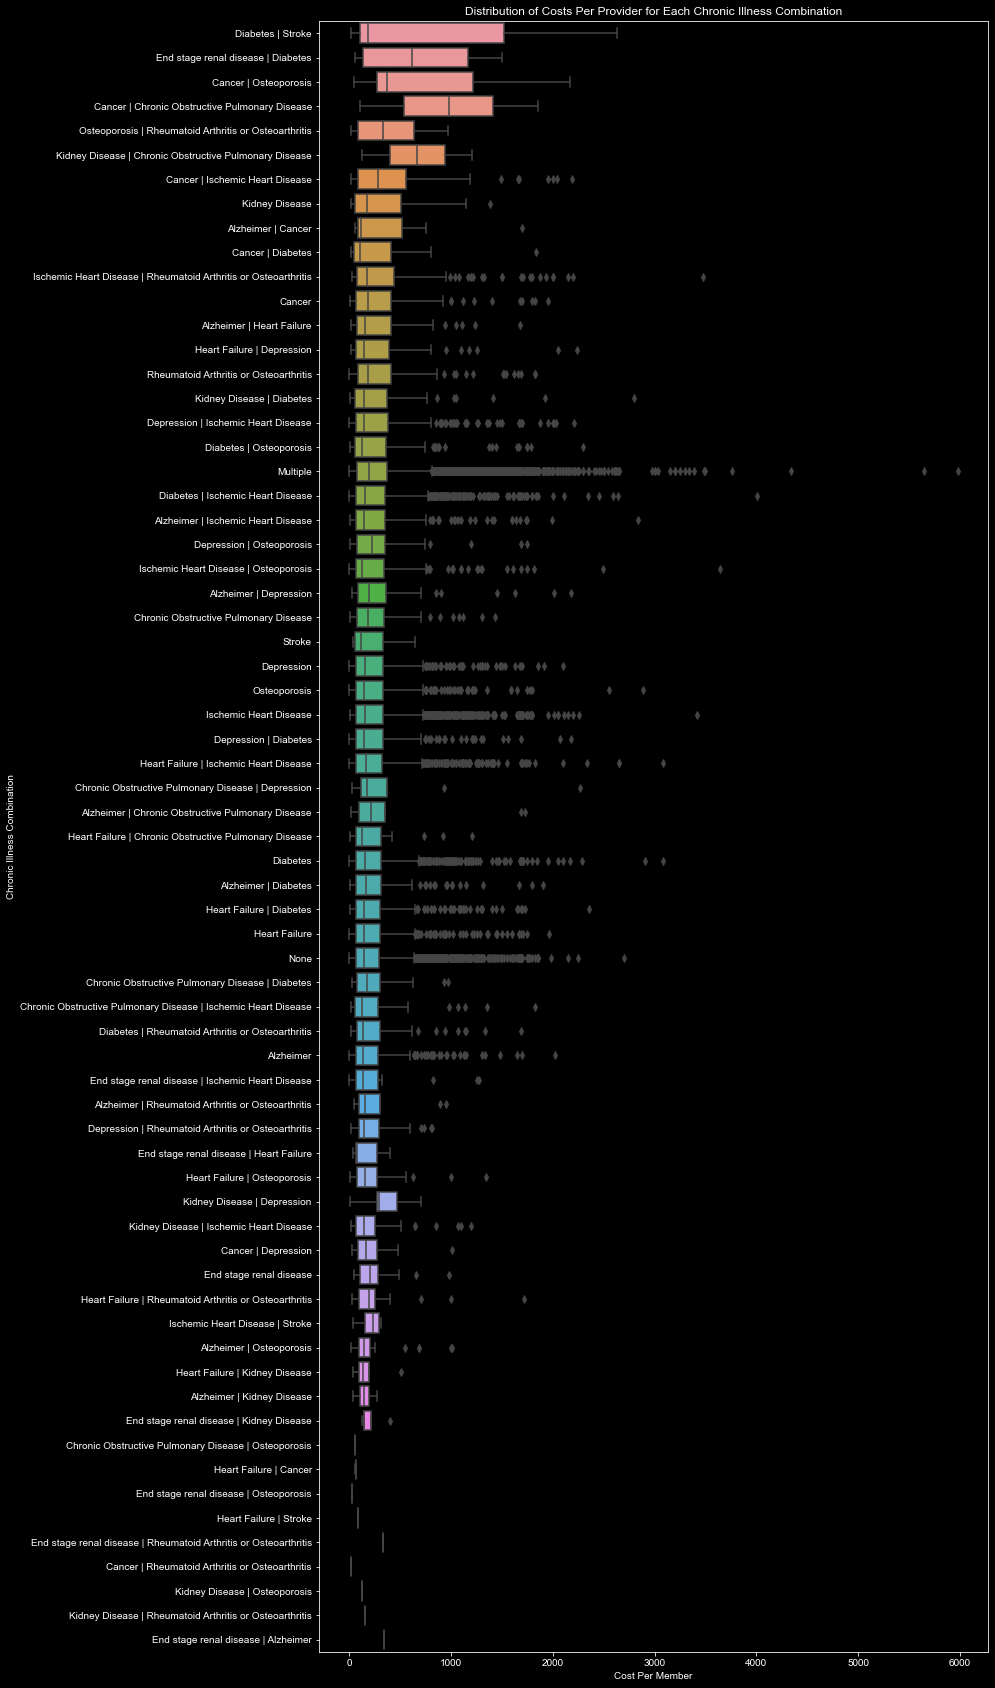

In [70]:


# Assuming you have a DataFrame provider_condition_grouped_df

# Calculate the IQR for each group
iqr_values = provider_condition_grouped_df.groupby('combined_condition')['cost_per_member'].quantile(0.75) - provider_condition_grouped_df.groupby('combined_condition')['cost_per_member'].quantile(0.25)

# Sort the groups by decreasing IQR
sorted_conditions = iqr_values.sort_values(ascending=False).index

# Create a horizontal boxplot using seaborn with the sorted order
fig, ax = plt.subplots(figsize=(12, 30))
sns.boxplot(x='cost_per_member', y='combined_condition', data=provider_condition_grouped_df, order=sorted_conditions)

# Customize the plot
ax.set_title('Distribution of Costs Per Provider for Each Chronic Illness Combination')
ax.set_xlabel('Cost Per Member')
ax.set_ylabel('Chronic Illness Combination')

# Show the plot
plt.show()


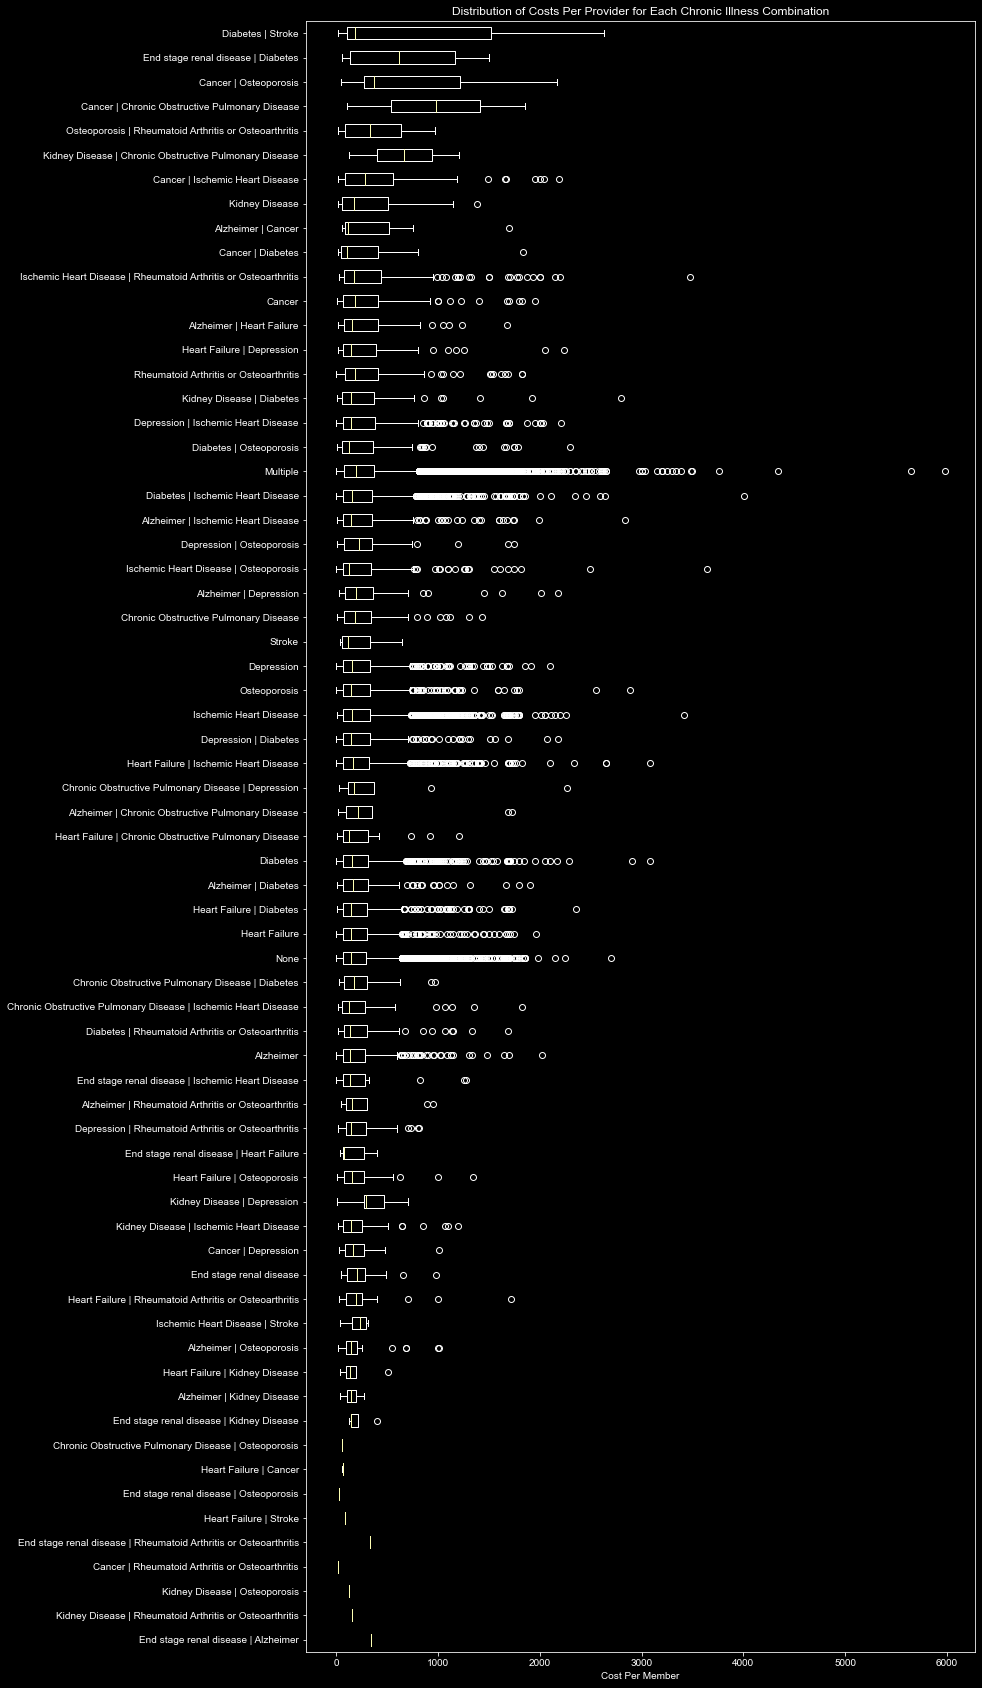

In [60]:

# Calculate the IQR for each group
iqr_values = provider_condition_grouped_df.groupby('combined_condition')['cost_per_member'].quantile(0.75) - provider_condition_grouped_df.groupby('combined_condition')['cost_per_member'].quantile(0.25)

# Sort the groups by decreasing IQR
sorted_conditions = iqr_values.sort_values(ascending=True).index

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 30))

# Plot horizontal boxplot
boxplot = ax.boxplot([provider_condition_grouped_df[provider_condition_grouped_df['combined_condition'] == condition]['cost_per_member'] for condition in sorted_conditions], vert=False, labels=sorted_conditions)

# Customize the plot
ax.set_title('Distribution of Costs Per Provider for Each Chronic Illness Combination')
ax.set_xlabel('Cost Per Member')
# ax.set_ylabel('Chronic Illness Combination')

# Show the plot
plt.show()


In [61]:
from scipy.stats import percentileofscore

# Assuming you have a DataFrame provider_condition_grouped_df

# Calculate the percentile for each row
provider_condition_grouped_df['percentile'] = provider_condition_grouped_df.groupby('AT_PHYSN_NPI')['cost_per_member'].apply(
    lambda x: x.apply(lambda y: percentileofscore(x, y))
)

# Calculate the median cost per member across providers for each combined_condition
provider_condition_grouped_df['median_cost_per_member_across_providers'] = provider_condition_grouped_df.groupby('combined_condition')['cost_per_member'].transform('median')

provider_condition_grouped_df

,AT_PHYSN_NPI,combined_condition,total_cost,beneficiary_count,cost_per_member_per_provider,cost_per_member,percentile,median_cost_per_member_across_providers
189985,9453890658.00,Multiple,11960.00,2,5980.00,5980.00,100.00,192.00
155476,7734578250.00,Multiple,16940.00,3,5646.67,5646.67,100.00,192.00
175094,8712278179.00,Multiple,17340.00,4,4335.00,4335.00,100.00,192.00
103005,5088396912.00,Diabetes | Ischemic Heart Disease,8010.00,2,4005.00,4005.00,100.00,150.00
168836,8402307293.00,Multiple,22580.00,6,3763.33,3763.33,100.00,192.00
...,...,...,...,...,...,...,...,...
32549,1630467098.00,Multiple,0.00,2,0.00,0.00,100.00,192.00
57594,2869707468.00,Multiple,0.00,2,0.00,0.00,100.00,192.00
33888,1693176609.00,Depression | Diabetes,0.00,2,0.00,0.00,50.00,145.00
134666,6694783240.00,Multiple,0.00,2,0.00,0.00,100.00,192.00


In [71]:
filtered_df = beneficiary_claims_df[
    (provider_condition_grouped_df['combined_condition'] != 'Multiple') & 
    (provider_condition_grouped_df['combined_condition'] != 'None')
    ].sort_values(by=['AT_PHYSN_NPI', 'combined_condition'])


/Users/anjalikarimpil/projects/takehome-challenges/UHG-DS/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [ ]:
(provider_condition_grouped_df
 .sort_values(by=['AT_PHYSN_NPI', 'combined_condition']))

In [ ]:
grouped_stats = (filtered_df
                 .groupby(['AT_PHYSN_NPI', 'combined_condition'])['cost_per_member']
                 .agg(['mean', 'median', 'std', 'count'])
                 .reset_index())
grouped_stats_df = pd.merge(grouped_stats, condition_grouped_df, on=['combined_condition'])
# grouped_stats_df = grouped_stats_df.drop(['total_cost', 'beneficiary_count', 'claim_count'], axis=1)
grouped_stats_df['diff'] = grouped_stats_df['median'] - grouped_stats_df['cost_per_member']


grouped_stats_df.sort_values(by=['diff'], ascending=False)

            

In [63]:
# Filter groups with count greater than 1
grouped_stats_filtered = grouped_stats_df[grouped_stats_df['count'] > 1]

# Reset index after filtering
grouped_stats_filtered = grouped_stats_filtered.reset_index(drop=True)
grouped_stats_filtered.sort_values(by=['diff'], ascending=False)

KeyError: 'count'

/Users/anjalikarimpil/projects/takehome-challenges/UHG-DS/venv/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/Users/anjalikarimpil/projects/takehome-challenges/UHG-DS/venv/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



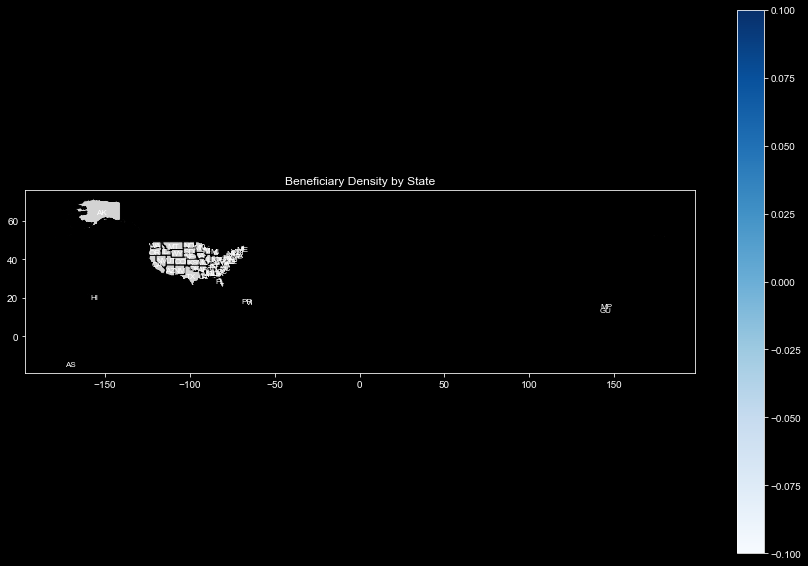

In [111]:
state_codes_str = '''01 AL 02 AK 03 AZ 04 AR 05 CA 06 CO 07 CT 08 DE 09 DC 10 
FL 11 GA 12 HI 13 ID 14 IL 15 IN 16 IA 17 KS 18 KY 19 LA 20 
ME 21 MD 22 MA 23 MI 24 MN 25 MS 26 MO 27 MT 28 NE 29 NV 30 
NH 31 NJ 32 NM 33 NY 34 NC 35 ND 36 OH 37 OK 38 OR 39 PA 41 
RI 42 SC 43 SD 44 TN 45 TX 46 UT 47 VT 49 VA 50 WA 51 WV 52 
WI 53 WY 54 Others
'''

state_codes_dict = {}
words = state_codes_str.split()
for i in range(0, len(words), 2):
    state_codes_dict[words[i]] = words[i+1] 

state_density = (
    beneficiary_df
    .groupby(['SP_STATE_CODE'])
    .agg(beneficiary_density = ('DESYNPUF_ID', 'count'))
).reset_index()

# import geopandas as gpd


# Load the GeoJSON file with state boundaries
geojson_path = 'us_states.geojson'
us_states = gpd.read_file(geojson_path)



# Merge the GeoDataFrame with your DataFrame based on the state code
merged_df = us_states.merge(state_density, left_on='abbr', right_on='SP_STATE_CODE', how='left')

# Plot the map
fig, ax = plt.subplots(figsize=(15, 10))
us_states.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot the beneficiary density in each state
merged_df.plot(column='beneficiary_density', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, vmin=merged_df['beneficiary_density'].min(), vmax=merged_df['beneficiary_density'].max())

# Add state labels
for x, y, label in zip(us_states.geometry.centroid.x, us_states.geometry.centroid.y, us_states['abbr']):
    ax.text(x, y, label, fontsize=8, ha='center', va='center')

plt.title('Beneficiary Density by State')
plt.show()


,SP_STATE_CODE,beneficiary_density
0,01,2537
1,02,233
2,03,2277
3,04,1772
4,05,9860
5,06,2015
6,07,1485
7,08,511
8,09,282
9,10,7614


In [66]:
average_cost_per_provider = provider_condition_grouped_df.groupby(['AT_PHYSN_NPI', 'combined_condition'])['cost_per_member_per_provider'].median().reset_index()

# Step 2: Identify providers with consistently high average costs across chronic illnesses
consistently_expensive_providers = average_cost_per_provider.groupby('AT_PHYSN_NPI')['cost_per_member_per_provider'].median().sort_values(ascending=False)

# Display the results
print(consistently_expensive_providers.head(50))

AT_PHYSN_NPI
9453890658.00   5980.00
7734578250.00   5646.67
8712278179.00   4335.00
8670780736.00   3490.00
7548046366.00   3488.75
5968076347.00   3390.00
1245852430.00   3340.00
2450785279.00   3300.00
5353245746.00   3250.00
9331308253.00   3200.00
7480442876.00   3200.00
9424315834.00   3153.33
3325423199.00   3035.00
652444265.00    3000.00
2135191114.00   3000.00
7358772292.00   2975.00
3534822596.00   2650.00
8342427586.00   2650.00
4342927911.00   2650.00
3683552594.00   2633.33
8784806690.00   2624.00
7826932984.00   2600.00
3224117096.00   2580.00
6102898929.00   2542.50
895042676.00    2500.00
7634790249.00   2500.00
3145948626.00   2500.00
751608638.00    2450.00
8770324535.00   2425.00
6104899074.00   2400.00
384890847.00    2350.00
810050560.00    2300.00
2254625155.00   2300.00
7862919311.00   2260.00
6210901577.00   2250.00
9975935643.00   2220.00
4518396428.00   2213.33
2866314646.00   2200.00
8049657399.00   2175.00
6057373981.00   2165.00
5494803043.00   2150.00
730

### References
1. CMS Linkable 2008–2010 Medicare DE-SynPUF [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/SynPUF_DUG.pdf]
2. Codebook for CMS Linkable 2008–2010 Medicare DE-SynPUF [https://www.cms.gov/files/document/de-10-codebook.pdf-0]